In [128]:
import pandas as pd
import numpy as np
import os
# Pycaret
from pycaret.classification import *
# Plots
from plotly.offline import iplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
# Sklearn tools
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
# Extras
from datetime import date
import warnings
warnings.filterwarnings("ignore")
# Datapath and Setup
os.chdir("..")
PATH = os.getcwd()+os.sep
RANDOM_SEED = 142
K_FOLDS = 5

In [129]:
def dataset_info(dataset, dataset_name: str):
    print(f"Dataset Name: {dataset_name} \
        | Number of Samples: {dataset.shape[0]} \
        | Number of Columns: {dataset.shape[1]}")
    print(30 * "=")
    print("Column             Data Type")
    print(dataset.dtypes)
    print(30 * "=")
    missing_data = dataset.isnull().sum()
    if sum(missing_data) > 0:
        print(missing_data[missing_data.values > 0])
    else:
        print("No Missing Data on this Dataset!")
    print(30 * "=")
    print("Memory Usage: {} MB".format(
        np.round(dataset.memory_usage(index=True).sum() / 10e5, 3)
    ))

# Dataset Sampling
def data_sampling(dataset, frac: float, random_seed: int):
    data_sampled_a = dataset.sample(frac=frac, random_state=random_seed)
    data_sampled_b = dataset.drop(data_sampled_a.index).reset_index(drop=True)
    data_sampled_a.reset_index(drop=True, inplace=True)
    return data_sampled_a, data_sampled_b

# Bar Plot
def bar_plot(data, plot_title: str, x_axis: str, y_axis: str):
    colors = ["#0080ff", ] * len(data)
    colors[0] = "#ff8000"
    trace = go.Bar(
        y=data.values,
        x=data.index,
        text=data.values,
        marker_color=colors,
    )
    layout = go.Layout(
        autosize=False,
        height=600,
        title={
            "text": plot_title,
            "y": 0.9,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        xaxis={"title": x_axis},
        yaxis={"title": y_axis},
    )
    fig = go.Figure(data=trace, layout=layout)
    fig.update_layout(template="simple_white")
    fig.update_traces(
        textposition="outside",
        textfont_size=14,
        marker=dict(line=dict(color="#000000", width=2)),
    )
    fig.update_yaxes(automargin=True)
    iplot(fig)

# Plot Pie Chart
def pie_plot(data, plot_title: str):
    trace = go.Pie(labels=data.index, values=data.values)
    layout = go.Layout(
        autosize=False,
        title={
            "text": plot_title,
            "y": 0.9,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
    )
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(
        textfont_size=14,
        marker=dict(line=dict(color="#000000", width=2)),
    )
    fig.update_yaxes(automargin=True)
    iplot(fig)

# Histogram
def histogram_plot(data, plot_title: str, y_axis: str):
    trace = go.Histogram(x=data)
    layout = go.Layout(
        autosize=False,
        title={
            "text": plot_title,
            "y": 0.9,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        yaxis={"title": y_axis},
    )
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(marker=dict(line=dict(color="#000000", width=2)))
    fig.update_layout(template="simple_white")
    fig.update_yaxes(automargin=True)
    iplot(fig)

# Particular case: Histogram subplot (1, 2)
def histogram_subplot(
    dataset_a,
    dataset_b,
    feature_a: str,
    feature_b: str,
    title: str,
    title_a: str,
    title_b: str,
):
    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=(title_a, title_b),
    )
    fig.add_trace(
        go.Histogram(x=dataset_a[feature_a], showlegend=False),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Histogram(x=dataset_b[feature_b], showlegend=False),
        row=1,
        col=2,
    )
    fig.update_layout(template="simple_white")
    fig.update_layout(
        autosize=False,
        title={
            "text": title,
            "y": 0.9,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        yaxis={"title": "<i>Frequency</i>"},
    )
    fig.update_traces(marker=dict(line=dict(color="#000000", width=2)))
    fig.update_yaxes(automargin=True)
    iplot(fig)


# EVALUATION HELPERS 

# Calculate scores with Test/Unseen labeled data
def test_score_report(data_unseen, predict_unseen):
    """
    data_unseen: original unseen data with 'Churn' column ("Yes"/"No")
    predict_unseen: output of predict_model(final_model, data=...)
                    with 'prediction_label' and 'prediction_score'
    """
    # Ensure consistent binary encoding: Yes=1, No=0
    y_true = (data_unseen["Churn"] == "Yes").astype(int)
    y_pred = (predict_unseen["prediction_label"] == "Yes").astype(int)

    # For AUC, use predicted probability of positive class
    if "prediction_score" in predict_unseen.columns:
        y_score = predict_unseen["prediction_score"]
        roc_auc = roc_auc_score(y_true, y_score)
    else:
        roc_auc = roc_auc_score(y_true, y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    df_unseen = pd.DataFrame(
        {
            "Accuracy": [accuracy],
            "AUC": [roc_auc],
            "Recall": [recall],
            "Precision": [precision],
            "F1 Score": [f1],
        }
    )
    return df_unseen

# Confusion Matrix
def conf_mat(data_unseen, predict_unseen):
    y_true = (data_unseen["Churn"] == "Yes").astype(int)
    y_pred = (predict_unseen["prediction_label"] == "Yes").astype(int)

    cmtx = confusion_matrix(y_true, y_pred, labels=[0, 1])

    ax = sns.heatmap(
        cmtx,
        annot=True,
        fmt="d",
        cmap="YlGnBu",
        xticklabels=["No", "Yes"],
        yticklabels=["No", "Yes"],
    )
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")
    ax.set_title("Predict Unseen Confusion Matrix", size=14)

In [130]:
dataset = pd.read_csv("C:/Users/honey.000/OneDrive/Documents/python/Assignments/EAI/Customer.csv")
dataset.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [131]:
dataset[dataset.duplicated()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [132]:
dataset_info(dataset, "customers")

Dataset Name: customers         | Number of Samples: 7043         | Number of Columns: 21
Column             Data Type
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
No Missing Data on this Dataset!
Memory Usage: 1.183 MB


In [133]:
dataset["TotalCharges"] = pd.to_numeric(dataset["TotalCharges"], errors="coerce")
dataset["TotalCharges"].fillna(dataset["TotalCharges"].mean(), inplace=True)


In [134]:
pie_plot(dataset["Churn"].value_counts(), 
         plot_title="<b>Client Churn Distribution<b>")

In [135]:
df_aux = dataset.query('Churn == "No"')
df_aux = df_aux["Contract"].value_counts()
bar_plot(df_aux, "<b>Contract Types of not Churned Clients</b>",
         "<i>Contract</i>", "<i>Count</i>")

In [136]:
df_aux = dataset.query('Churn == "Yes"')
df_aux = df_aux["Contract"].value_counts()
bar_plot(df_aux, "<b>Contract Types of Churned Clients</b>",
         "<i>Contract</i>", "<i>Count</i>")

In [137]:
df_aux = dataset.query('(Contract == "Month-to-month") and (Churn == "No")')
histogram_subplot(df_aux, df_aux, "MonthlyCharges", "TotalCharges", 
                  "<b>Charges Distribution for Month-to-month contracts for not Churned Clients</b>",
                  "(a) Monthtly Charges Distribution", "(b) Total Charges Distribution")

In [138]:
df_aux = dataset.query('(Contract == "Month-to-month") and (Churn == "Yes")')
histogram_subplot(df_aux, df_aux, "MonthlyCharges", "TotalCharges", 
                  "<b>Charges Distribution for Month-to-month contracts for Churned Clients</b>",
                  "(a) Monthtly Charges Distribution", "(b) Total Charges Distribution")

In [139]:
df_aux = dataset.query('Contract == "Month-to-month" and Churn == "Yes"')
df_aux = df_aux["PaymentMethod"].value_counts()
bar_plot(
    df_aux,
    "<b>Payment Method of Month-to-month contract Churned Clients</b>",
    "<i>Payment Method</i>",
    "<i>Count</i>",
)

In [140]:
df_aux = dataset.query(('Contract == Month-to-month') and ('Churn == "Yes"'))
df_aux = df_aux["tenure"].value_counts().head(5)
bar_plot(df_aux, "<b>Tenure of Month-to-month contract for Churned Clients</b>",
         "<i>Tenure</i>", "<i>Count</i>")

In [141]:
data, data_unseen = data_sampling(dataset, 0.9, RANDOM_SEED)
print(f"There are {data_unseen.shape[0]} samples for Unseen Data.")

There are 704 samples for Unseen Data.


In [142]:
exp01 = setup(
    data=data,
    target="Churn",
    session_id=RANDOM_SEED,
    ignore_features=["customerID"],
    numeric_features=["SeniorCitizen"],
    imputation_type="simple",
    numeric_imputation="mean",
    categorical_imputation="mode",
    normalize=True,
    normalize_method="zscore",
    transformation=True,
    transformation_method="yeo-johnson",
    feature_selection=True,
    n_features_to_select=0.8,
    pca=True,
    pca_method="linear",
    remove_outliers=True,
    outliers_method="iforest",
    outliers_threshold=0.05,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,
    fix_imbalance=True,
    bin_numeric_features=["MonthlyCharges", "TotalCharges"],
    log_experiment=False,
    html=True,
    verbose=True
)


Traceback (most recent call last):
  File "c:\Users\honey.000\AppData\Local\Programs\Python\Python310\lib\site-packages\pycaret\internal\logging.py", line 146, in create_logger
    ch = logging.FileHandler(path)
  File "c:\Users\honey.000\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1169, in __init__
    StreamHandler.__init__(self, self._open())
  File "c:\Users\honey.000\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1201, in _open
    return open_func(self.baseFilename, self.mode,
PermissionError: [Errno 13] Permission denied: 'c:\\Users\\logs.log'


[LightGBM] [Info] Number of positive: 3048, number of negative: 3048
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 6096, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,Description,Value
0,Session id,142
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(6339, 21)"
5,Transformed data shape,"(7998, 16)"
6,Transformed train set shape,"(6096, 16)"
7,Transformed test set shape,"(1902, 16)"
8,Ignore features,1
9,Numeric features,1


In [143]:
top_model = compare_models(fold=K_FOLDS,
                            sort="F1",
                            n_select=1, 
                            exclude=["gbc", "catboost"])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:30:35
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7749,0.8284,0.7749,0.7853,0.7786,0.4486,0.4509,1.4400
lightgbm,Light Gradient Boosting Machine,0.7794,0.8152,0.7794,0.7752,0.7768,0.4260,0.4268,0.4360
lda,Linear Discriminant Analysis,0.7694,0.8305,0.7694,0.7858,0.7752,0.4465,0.4505,0.3060
ridge,Ridge Classifier,0.7688,0.8305,0.7688,0.7855,0.7746,0.4456,0.4497,0.3120
rf,Random Forest Classifier,0.7769,0.8077,0.7769,0.7694,0.7721,0.4092,0.4110,0.5160
ada,Ada Boost Classifier,0.7690,0.8036,0.7690,0.7700,0.7689,0.4123,0.4133,0.4300
et,Extra Trees Classifier,0.7737,0.7956,0.7737,0.7634,0.7667,0.3915,0.3945,0.4080
svm,SVM - Linear Kernel,0.7593,0.8068,0.7593,0.7697,0.7622,0.4063,0.4099,0.3400
knn,K Neighbors Classifier,0.7212,0.7696,0.7212,0.7532,0.7315,0.3559,0.3637,1.1240
dt,Decision Tree Classifier,0.7115,0.6592,0.7115,0.7227,0.7162,0.2917,0.2928,0.3440


In [144]:
tuned_model = tune_model(estimator=top_model, fold=K_FOLDS,
                         optimize="F1", choose_better=True,
                         verbose=False)

In [145]:
plot_model(tuned_model, plot="parameter")

,Parameters
C,3.683
class_weight,{}
dual,False
fit_intercept,True
intercept_scaling,1
l1_ratio,None
max_iter,1000
multi_class,auto
n_jobs,None
penalty,l2


In [146]:
bagged_model = ensemble_model(tuned_model, fold=K_FOLDS)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7613,0.8191,0.7613,0.7753,0.7667,0.4223,0.4248
1,0.7793,0.8287,0.7793,0.7882,0.7830,0.4590,0.4604
2,0.7971,0.8436,0.7971,0.8017,0.7991,0.4939,0.4944
3,0.7790,0.8167,0.7790,0.7939,0.7845,0.4684,0.4717
4,0.7835,0.8258,0.7835,0.7777,0.7801,0.4321,0.4330
Mean,0.7800,0.8268,0.7800,0.7874,0.7827,0.4551,0.4569
Std,0.0115,0.0094,0.0115,0.0099,0.0103,0.0257,0.0255


In [147]:
boosted_model = ensemble_model(tuned_model, fold=K_FOLDS,
                               method="Bagging")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7613,0.8191,0.7613,0.7753,0.7667,0.4223,0.4248
1,0.7793,0.8287,0.7793,0.7882,0.7830,0.4590,0.4604
2,0.7971,0.8436,0.7971,0.8017,0.7991,0.4939,0.4944
3,0.7790,0.8167,0.7790,0.7939,0.7845,0.4684,0.4717
4,0.7835,0.8258,0.7835,0.7777,0.7801,0.4321,0.4330
Mean,0.7800,0.8268,0.7800,0.7874,0.7827,0.4551,0.4569
Std,0.0115,0.0094,0.0115,0.0099,0.0103,0.0257,0.0255


In [148]:
blended_model = blend_models(estimator_list=[tuned_model, boosted_model],
                            fold=K_FOLDS)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7635,0.8186,0.7635,0.7775,0.7689,0.4278,0.4303
1,0.7770,0.8287,0.7770,0.7868,0.7810,0.4548,0.4564
2,0.7948,0.8435,0.7948,0.8007,0.7973,0.4910,0.4917
3,0.7790,0.8168,0.7790,0.7939,0.7845,0.4684,0.4717
4,0.7835,0.8260,0.7835,0.7792,0.7811,0.4367,0.4372
Mean,0.7796,0.8267,0.7796,0.7876,0.7826,0.4557,0.4575
Std,0.0101,0.0095,0.0101,0.0088,0.0091,0.0226,0.0225


In [149]:
best_model = boosted_model
plot_model(best_model, plot="parameter")
print(f"Model: {type(best_model)}")

,Parameters
bootstrap,True
bootstrap_features,False
estimator,"LogisticRegression(C=3.683, class_weight={}, d..."
max_features,1.0
max_samples,1.0
n_estimators,10
n_jobs,None
oob_score,False
random_state,142
verbose,0


Model: <class 'sklearn.ensemble._bagging.BaggingClassifier'>


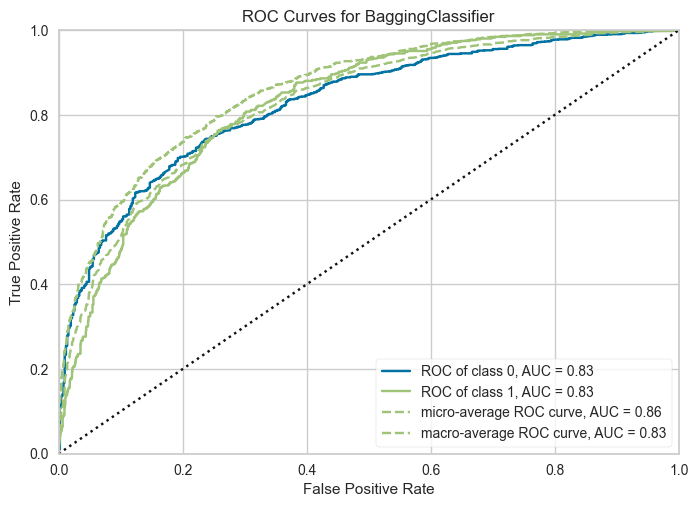

In [150]:

plot_model(best_model, plot="auc")

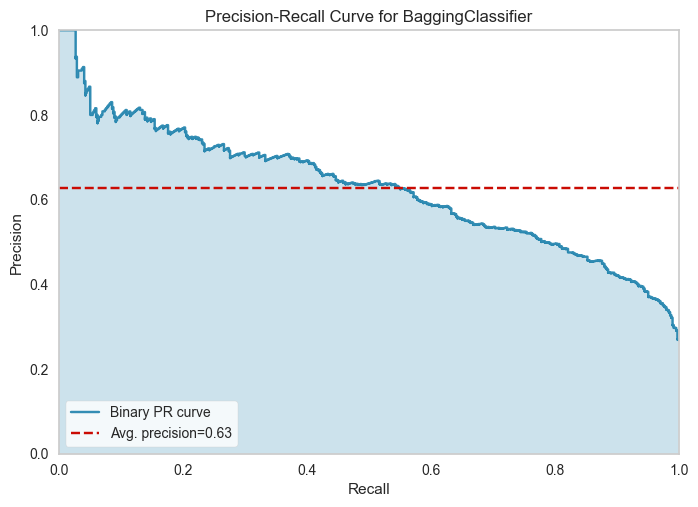

In [151]:
plot_model(best_model, plot="pr")

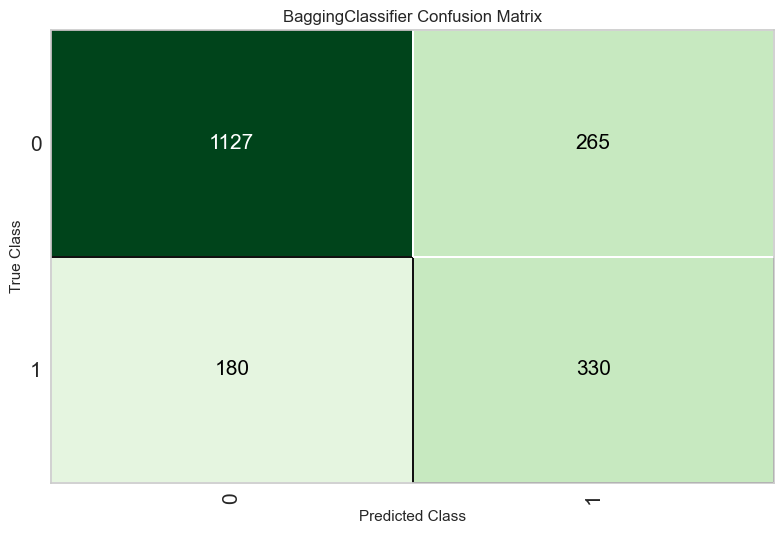

In [152]:
plot_model(best_model, plot="confusion_matrix")

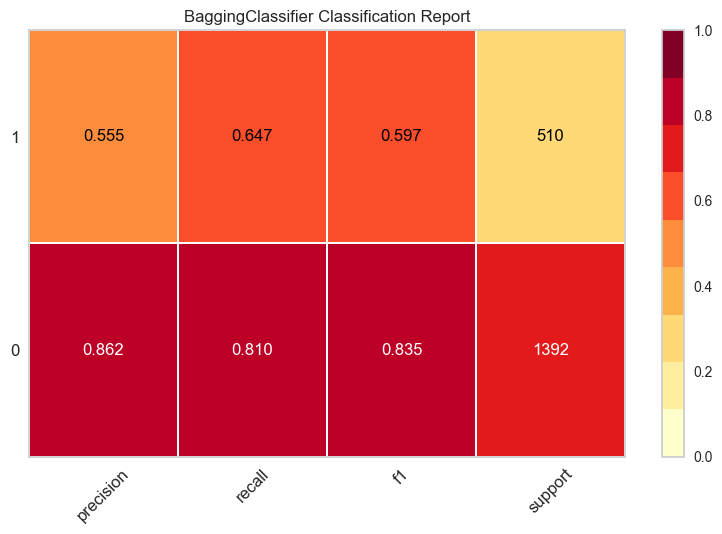

In [153]:
plot_model(best_model, plot="class_report")

In [154]:
predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7660,0.8274,0.7660,0.7798,0.7714,0.4338,0.4363


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,prediction_label,prediction_score
1056,Male,0,No,No,20,Yes,Yes,DSL,No,Yes,...,Yes,No,One year,Yes,Electronic check,68.699997,1416.199951,No,Yes,0.6047
2164,Male,0,Yes,Yes,63,Yes,Yes,DSL,Yes,Yes,...,Yes,Yes,Two year,Yes,Credit card (automatic),89.400002,5597.649902,No,No,0.9134
481,Male,0,No,No,29,Yes,No,Fiber optic,No,Yes,...,Yes,No,Month-to-month,No,Mailed check,89.650002,2623.649902,No,No,0.8671
1765,Male,0,No,No,6,Yes,No,DSL,No,No,...,No,No,Month-to-month,No,Electronic check,44.750000,270.950012,Yes,Yes,0.6257
2674,Male,0,No,No,5,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,Month-to-month,No,Credit card (automatic),20.049999,95.550003,No,No,0.7892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,Female,1,Yes,No,56,Yes,Yes,DSL,Yes,Yes,...,No,No,One year,Yes,Credit card (automatic),68.449997,4014.000000,No,No,0.9413
5081,Female,0,Yes,No,64,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,Two year,No,Credit card (automatic),19.450001,1208.599976,No,No,0.9900
935,Male,1,No,No,2,Yes,No,DSL,No,No,...,No,No,Month-to-month,Yes,Electronic check,44.700001,93.699997,Yes,Yes,0.8438
4663,Male,1,Yes,No,6,Yes,Yes,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,80.800003,457.100006,No,Yes,0.8378


In [155]:
final_model = finalize_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8182,0.8646,0.8182,0.8264,0.8216,0.5193,0.5208


 Accuracy      AUC   Recall  Precision  F1 Score
 0.818182 0.325959 0.678571   0.606383  0.640449


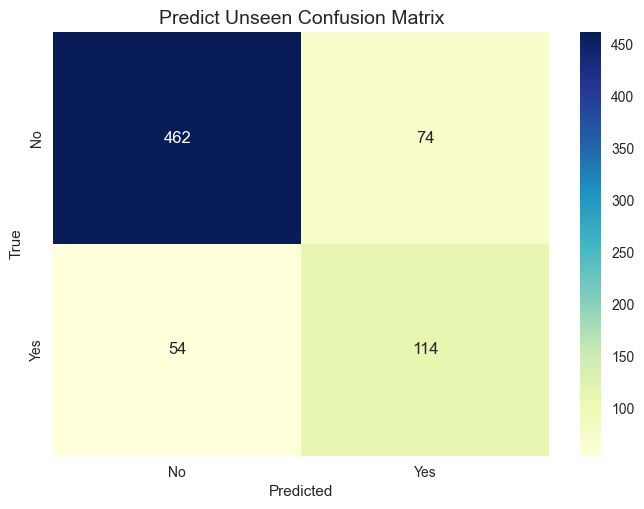

In [157]:
predict_unseen = predict_model(final_model, data=data_unseen)
score_unseen = test_score_report(data_unseen, predict_unseen)
print(score_unseen.to_string(index=False))
conf_mat(data_unseen, predict_unseen)

In [168]:
save_model(
    final_model,
    "C:/Users/honey.000/OneDrive/Documents/python/Assignments/EAI" + date.today().strftime("%m-%d-%Y")
)


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['SeniorCitizen'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strate...
                                    estimator=LogisticRegression(C=3.683,
                                                                 class_weight={},
             